In [1]:
import numpy as np
import pandas as pd
from itertools import combinations
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import trange, tqdm

# (a) Split the original data

In [2]:
# Get proper file path separator for current OS
s = os.path.sep

###### The code block below is only used when importing selected subset of variables 

In [ ]:
# # Get all column names
# all_cols = pd.read_csv("D:" + s + "2022 Spring" + s + "ISYE7406" + s + "HW" + s + "HW2" + s + "fat.csv").columns.tolist()

# # Change cols as needed
# all_cols.remove('siri')
# all_cols.remove('free')
# all_cols.remove('density')

# # Import data with only selected columns
# fat = pd.read_csv("D:" + s + "2022 Spring" + s + "ISYE7406" + s + "HW" + s + "HW2" + s + "fat.csv", usecols = all_cols)

###### The code block above is only used when importing selected subset of variables 

In [3]:
# Import original data
fat = pd.read_csv("D:" + s + "2022 Spring" + s + "ISYE7406" + s + "HW" + s + "HW2" + s + "fat.csv")

In [4]:
# Index for 25 rows of testing observations in R
test_index_R = [1,21,22,57,70,88,91,94,121,127,149,151,159,162,164,177,179,194,206,214,215,221,240,241,243 ]

In [5]:
# Convert index in R to Python. Python index starts from 0
test_index_Python = [x - 1 for x in test_index_R]

In [6]:
# Get the testing data
#fat1test = fat.iloc[test_index_Python, :]

test = fat.iloc[test_index_Python, :]

In [7]:
# Get the training data
#fat1train = fat.drop(index = test_index_Python)

train = fat.drop(index = test_index_Python)

# (b) Exploratory data analysis 

## Check for missing values in the original data

In [8]:
fat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   brozek   252 non-null    float64
 1   siri     252 non-null    float64
 2   density  252 non-null    float64
 3   age      252 non-null    int64  
 4   weight   252 non-null    float64
 5   height   252 non-null    float64
 6   adipos   252 non-null    float64
 7   free     252 non-null    float64
 8   neck     252 non-null    float64
 9   chest    252 non-null    float64
 10  abdom    252 non-null    float64
 11  hip      252 non-null    float64
 12  thigh    252 non-null    float64
 13  knee     252 non-null    float64
 14  ankle    252 non-null    float64
 15  biceps   252 non-null    float64
 16  forearm  252 non-null    float64
 17  wrist    252 non-null    float64
dtypes: float64(17), int64(1)
memory usage: 35.6 KB


## Descriptive statistics for each column

In [9]:
# Descriptive statistics for training data
train.describe().style.format(precision = 2)

,brozek,siri,density,age,weight,height,adipos,free,neck,chest,abdom,hip,thigh,knee,ankle,biceps,forearm,wrist
count,227.00,227.00,227.00,227.00,227.00,227.00,227.00,227.00,227.00,227.00,227.00,227.00,227.00,227.00,227.00,227.00,227.00,227.00
mean,18.99,19.21,1.06,44.98,179.26,70.16,25.45,143.78,37.99,100.87,92.65,100.00,59.48,38.60,23.11,32.34,28.65,18.24
std,7.92,8.55,0.02,12.51,29.58,3.76,3.69,18.34,2.47,8.55,10.98,7.26,5.33,2.42,1.70,3.02,1.95,0.92
min,0.00,0.00,0.99,22.00,118.50,29.50,18.10,107.90,31.10,79.30,69.40,85.00,47.20,33.00,19.10,24.80,21.00,15.80
25%,12.75,12.30,1.04,36.50,159.75,68.25,23.10,131.30,36.40,94.75,84.90,95.60,56.00,36.95,22.05,30.30,27.30,17.60
50%,19.10,19.30,1.05,43.00,176.00,70.00,24.90,141.70,37.90,99.60,90.80,99.30,59.00,38.50,22.80,32.10,28.70,18.30
75%,24.65,25.35,1.07,54.00,197.50,72.25,27.20,153.95,39.50,105.45,99.80,103.35,62.40,39.95,23.85,34.40,30.00,18.80
max,45.10,47.50,1.11,81.00,363.15,77.75,48.90,240.50,51.20,136.20,148.10,147.70,87.30,49.10,33.90,45.00,33.80,21.40


In [10]:
# Who has brozek equal to zero?
train[train['brozek']==0]

,brozek,siri,density,age,weight,height,adipos,free,neck,chest,abdom,hip,thigh,knee,ankle,biceps,forearm,wrist
181,0.0,0.0,1.1089,40,118.5,68.0,18.1,118.5,33.8,79.3,69.4,85.0,47.2,33.5,20.2,27.7,24.6,16.5


## Correlations

Text(0.5, 1.0, 'Correlations among variables in fat data')

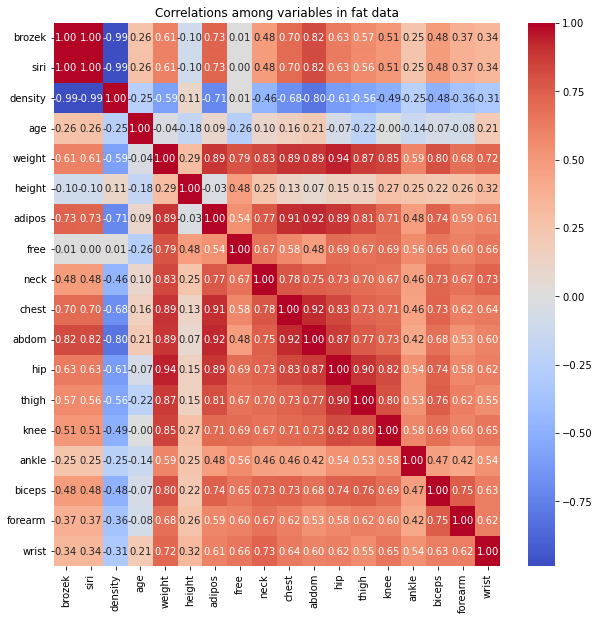

In [11]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(), center = 0, cmap = 'coolwarm', annot = True, fmt = '.2f')
plt.title('Correlations among variables in fat data')

## Outlier

In [12]:
# Standardize fat1train data
train_std_df = (train - train.mean()) / train.std()

Text(0.5, 1.0, 'Standardized train Data')

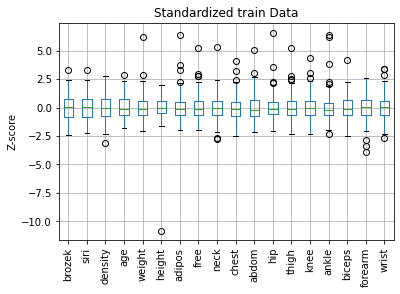

In [13]:
# Display the box plot for each variable
train_std_df.boxplot()
plt.xticks(rotation=90)
plt.ylabel('Z-score')
plt.title('Standardized train Data')


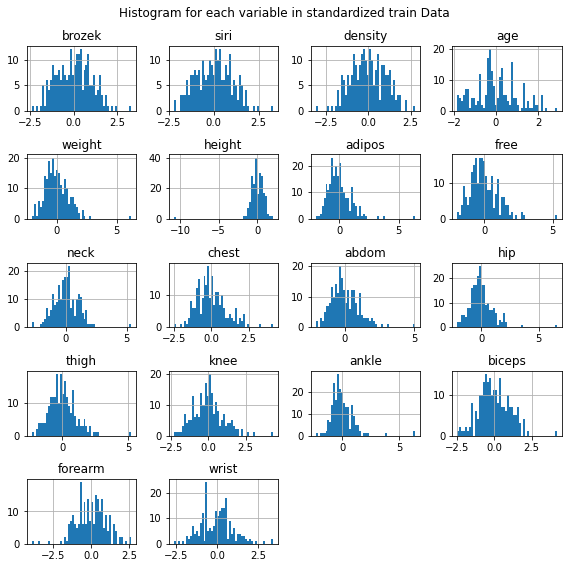

In [14]:
# Show histogram for each column of standardized fat1train
train_std_df.hist(bins = 50, figsize = (8, 8))
plt.suptitle('Histogram for each variable in standardized train Data')
plt.tight_layout()


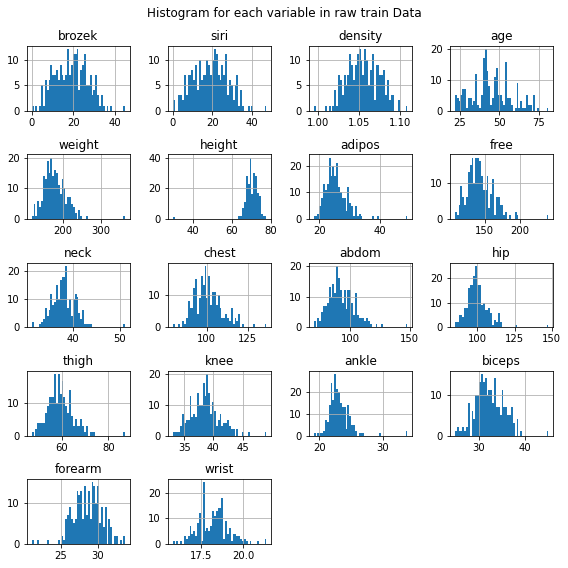

In [15]:
# Show histogram for each column of raw fat1train data
train.hist(bins = 50, figsize = (8, 8))
plt.suptitle('Histogram for each variable in raw train Data')
plt.tight_layout()


In [16]:
# Write a function to display outlier data entries
def show_outlier(df, z_score):
    # Standardize the input dataframe
    df_std = (df - df.mean()) / df.std()
    # Check each row to look for outlier based on z_score criteria input by the user
    df_std['is_outlier'] = (abs(df_std) > z_score).sum(axis = 1)
    # Select the outliers from standardized data
    outliers = df_std.loc[df_std['is_outlier'] != 0].drop('is_outlier', axis = 1)
    # Make the outliers pretty
    styler = outliers.style
    styler.set_caption("Display Outliers after Standardization")
    styler.format(precision = 2).apply(lambda x: ["background: yellow" if abs(v) > z_score else "" for v in x], axis = 1)
    
    return styler


In [17]:
# Show outliers, using z_score = 3 as threshold
show_outlier(train, 3)

,brozek,siri,density,age,weight,height,adipos,free,neck,chest,abdom,hip,thigh,knee,ankle,biceps,forearm,wrist
30,-0.84,-0.85,0.83,-1.04,0.09,0.95,-0.50,0.87,0.29,-0.04,-0.36,-0.03,-0.37,0.04,6.34,0.05,-0.49,0.17
38,1.87,1.87,-1.81,0.08,6.22,0.56,6.36,5.28,5.36,4.13,5.05,6.57,5.22,4.33,3.82,4.19,0.18,3.43
40,1.78,1.79,-1.73,0.00,2.82,-0.37,3.70,1.75,2.11,3.21,3.06,3.53,2.44,0.41,2.05,1.34,2.07,3.43
41,1.60,1.60,-1.57,-0.08,0.87,-10.81,1.21,-0.20,-0.56,0.60,1.06,2.13,2.09,1.61,0.35,0.42,0.03,-0.91
85,0.86,0.86,-0.87,1.76,-0.41,-0.71,0.15,-1.08,-0.60,-0.23,-0.27,-0.52,-0.90,-0.33,6.23,0.02,-0.49,-0.04
174,0.71,0.71,-0.72,-0.72,1.61,0.42,1.51,1.48,1.42,1.69,1.47,1.98,1.82,1.57,0.52,1.01,-3.91,2.02
215,3.29,3.31,-3.11,0.48,1.34,-1.64,3.30,-1.29,1.30,2.21,2.68,1.76,0.57,-0.70,0.29,0.78,0.23,0.17
225,-0.78,-0.78,0.76,0.80,-1.78,-0.91,-1.48,-1.83,-1.86,-1.41,-1.32,-1.72,-1.63,-2.31,-2.00,-2.33,-3.40,-2.64
243,1.57,1.57,-1.53,1.76,1.64,0.69,1.32,0.68,1.34,1.75,1.89,1.35,1.15,3.05,1.35,0.98,0.59,1.37


## Remove outliers from training data

In [18]:
# Remove outliers from training data
train_X = train.drop(show_outlier(train, 3).index).drop('brozek', axis = 1)
train_Y = train.drop(show_outlier(train, 3).index).loc[:, 'brozek']

In [19]:
# Prepare test data
test_X = test.drop('brozek', axis = 1)
test_Y = test.loc[:, 'brozek']

# (c) Build models

## Some useful functions

In [33]:
# Create a function to standardize X data
def standardize(df):
    sc = StandardScaler()
    return sc.fit_transform(df)

In [20]:
# Create a function to calculate errors
def calc_error(predict, real):
    diff_sqr = []
    for x, y in zip(predict, real):
        diff_sqr.append(pow(x-y, 2))
    error = sum(diff_sqr) / len(diff_sqr)
    
    return error

In [21]:
# Create a function to calculate AIC
def calc_aic(pred, real, n_param):
    mean_sse = calc_error(pred, real)
    aic = len(pred) * np.log(mean_sse) + 2 * n_param

    return aic

In [22]:
# Create a function to find the best subset of k
def find_best_k(model, X, Y, k):
    # Create a dict to store the searching results
    best_k = {'Variables':[], 'Train_Err':[]}
    # Search combinations of variables
    for cols in combinations(X.columns, k):
        # Subset the variables
        sub_X = X.loc[:,cols]
        # Standardize variables
        temp_sc = StandardScaler()
        sub_X_std = temp_sc.fit_transform(sub_X)
        # Fit the model
        model.fit(sub_X_std, Y)
        pred_train = model.predict(sub_X_std)
        train_err = calc_error(pred_train, Y)
        # Store the variable selection and corresponding training error
        best_k['Variables'].append(cols)
        best_k['Train_Err'].append(train_err)
    
    # Convert to dataframe
    best_k_df = pd.DataFrame.from_dict(best_k)
    
    # Sort the dataframe by training error
    best_k_sorted = best_k_df.sort_values(by = 'Train_Err')
    
    # Gather info for the best k
    best_params = best_k_sorted.iloc[0,0]
    best_error = best_k_sorted.iloc[0,1]
  
    # Store the info in a dictionary
    result = {}
    
    result['Best_param'] = best_params
    result['Best_error'] = best_error
    result['All_results'] = best_k_sorted
    
    return result
        
    

In [23]:
# Create a function to find best parameters stepwise using AIC
def find_best_stepwise(model, X, Y):
    initial_features = X.columns.tolist()
    best_features = []
    discarded = []
    remaining_features = [i for i in initial_features if i not in best_features and i not in discarded]
    
    while (len(remaining_features) > 0):
        
        remaining_features = [i for i in initial_features if i not in best_features and i not in discarded]
        current_features = best_features
        temp_fwd = {'combo':[], 'aic':[]}
        temp_bwd = {'combo':[], 'aic':[]}
        
        # Add one feature and calculate AIC
        for x in remaining_features:
            
            fwd_combo = current_features + [x]
            temp_fwd['combo'].append(fwd_combo)
            model.fit(standardize(X.loc[:, fwd_combo]), Y)
            fwd_pred = model.predict(standardize(X.loc[:, fwd_combo]))
            fwd_aic = calc_aic(fwd_pred, Y, len(fwd_combo))
            temp_fwd['aic'].append(fwd_aic)
         
        # Find minimum AIC
        temp_fwd_df = pd.DataFrame.from_dict(temp_fwd)
        fwd_best = temp_fwd_df.sort_values(by = 'aic').iloc[0]   
        best_features = fwd_best['combo']
        

        if len(fwd_best['combo']) > 1:
            
            # Remove one feature and calculate AIC again
            for y in combinations(fwd_best['combo'], len(fwd_best['combo'])-1):
            
                bwd_combo = y
                temp_bwd['combo'].append(bwd_combo)
                model.fit(standardize(X.loc[:, bwd_combo]), Y)
                bwd_pred = model.predict(standardize(X.loc[:, bwd_combo]))
                temp_bwd['aic'].append(calc_aic(bwd_pred, Y, len(bwd_combo)))
            
            # Find the minimum AIC
            temp_bwd_df = pd.DataFrame.from_dict(temp_bwd)
            bwd_best = temp_bwd_df.sort_values(by = 'aic').iloc[0]
        
            # Compare AIC between the minimum of one step forward and the minimum of one step backward
            if fwd_best['aic'] - bwd_best['aic'] <= -0.001:
                discarded.append(set(fwd_best['combo']) - set(bwd_best['combo']))
            else:
                best_features = bwd_best['combo']
                break
    
    return best_features
        

In [64]:
# Create a function to perform Monte Carlo CV
def MC_CV(model, data, test_size, B):
    test_error = []
    for i in tqdm(range(B)):
        # Random sample training and testing set
        temp_test = data.sample(test_size)
        temp_train = data.drop(labels = temp_test.index)
        
        temp_train_X = temp_train.drop('brozek', axis = 1)
        temp_train_Y = temp_train.loc[:,'brozek']
        
        temp_test_X = temp_test.drop('brozek', axis = 1)
        temp_test_Y = temp_test.loc[:, 'brozek']
        
        # Standardize data
        sc = StandardScaler()
        sc.fit(temp_train_X)
        temp_train_X_std = sc.transform(temp_train_X)
        temp_test_X_std = sc.transform(temp_test_X)
        
        # Fit the model
        model.fit(temp_train_X_std, temp_train_Y)
        temp_pred = model.predict(temp_test_X_std)
        
        # Calculate Testing Error
        te = calc_error(temp_pred, temp_test_Y)
        
        test_error.append(te)
    
    return test_error
        
        

## (1) Linear Regression using all predictors

In [25]:
# Standardize data for mod_1
sc_1 = StandardScaler()
sc_1.fit(train_X)
mod_1_train_X_std = sc_1.transform(train_X)
mod_1_test_X_std = sc_1.transform(test_X)

In [26]:
# Linear Regression using all predictors
mod_1 = LinearRegression()
mod_1.fit(mod_1_train_X_std, train_Y)


LinearRegression()

## (2) Linear Regression with the best subset k=5 

In [27]:
# Find the best 5 predictors
best_five = find_best_k(LinearRegression(), train_X, train_Y, 5)

In [28]:
# Show selected 5 variables
best_five['Best_param']

('siri', 'density', 'weight', 'free', 'knee')

In [29]:
# Subset the data based on the best 5 predictors
best_five_train_X = train_X.loc[:, best_five['Best_param']]
best_five_test_X = test_X.loc[:, best_five['Best_param']]

In [30]:
# Standardize data for mod_2
sc_2 = StandardScaler()
sc_2.fit(best_five_train_X)
mod_2_train_X_std = sc_2.transform(best_five_train_X)
mod_2_test_X_std = sc_2.transform(best_five_test_X)

In [31]:
# Linear Regression using only the best 5 predictors
mod_2 = LinearRegression()
mod_2.fit(mod_2_train_X_std, train_Y)

LinearRegression()

## (3) Linear Regression with stepwise-selected variables using AIC

In [34]:
# Stepwise select variables using AIC
best_param_aic = find_best_stepwise(LinearRegression(), train_X, train_Y)

In [35]:
# Show the selected variables
best_param_aic

('siri', 'density', 'forearm', 'biceps', 'knee', 'thigh', 'wrist')

In [36]:
# Subset the data based on the best variables
best_aic_train_X = train_X.loc[:, best_param_aic]
best_aic_test_X = test_X.loc[:, best_param_aic]

In [37]:
# Standardize data for mod_3
sc_3 = StandardScaler()
sc_3.fit(best_aic_train_X)
mod_3_train_X_std = sc_3.transform(best_aic_train_X)
mod_3_test_X_std = sc_3.transform(best_aic_test_X)

In [38]:
# Linear Regression using the bese variables
mod_3 = LinearRegression()
mod_3.fit(mod_3_train_X_std, train_Y)

LinearRegression()

## (4) Ridge regression

In [39]:
# Standardize data for mod_4
sc_4 = StandardScaler()
sc_4.fit(train_X)
mod_4_train_X_std = sc_4.transform(train_X)
mod_4_test_X_std = sc_4.transform(test_X)

In [40]:
# Ridge regression using cv
mod_4 = RidgeCV(alphas=[0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5, 10])
mod_4.fit(mod_4_train_X_std, train_Y)

RidgeCV(alphas=array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 5.e-01, 1.e+00, 5.e+00, 1.e+01]))

In [44]:
# Show the coeficients after Ridge regression
pd.Series(mod_4.coef_, index=train_X.columns).sort_values(ascending=False)

siri       7.153354
adipos     0.221830
height     0.159315
weight     0.148792
thigh      0.074909
forearm    0.052689
wrist      0.042971
abdom      0.007179
chest      0.002348
hip        0.000270
neck       0.000004
ankle     -0.000639
age       -0.009579
biceps    -0.057587
knee      -0.088945
density   -0.167787
free      -0.356611
dtype: float64

## (5) LASSO

In [45]:
# Standardize data for mod_5
sc_5 = StandardScaler()
sc_5.fit(train_X)
mod_5_train_X_std = sc_5.transform(train_X)
mod_5_test_X_std = sc_5.transform(test_X)

In [46]:
# LASSO
mod_5 = LassoCV()
mod_5.fit(mod_5_train_X_std, train_Y)

LassoCV()

In [47]:
# Show the coeficients after LASSO regression
pd.Series(mod_5.coef_, index=train_X.columns).sort_values(ascending=False)

siri       7.434226
thigh      0.004822
forearm    0.002665
abdom      0.000000
biceps     0.000000
ankle      0.000000
knee       0.000000
hip        0.000000
chest      0.000000
neck       0.000000
free       0.000000
adipos     0.000000
height     0.000000
weight     0.000000
age       -0.000000
wrist      0.000000
density   -0.134646
dtype: float64

## (6) Principal component regression

In [48]:
# Create a PCA object. We would like it to explain at least 95% of the variance in our data
pca = PCA(n_components = 0.95)
mod_6 = LinearRegression()

In [49]:
# Standardize data for PCA in mod_6
sc_6 = StandardScaler()
sc_6.fit(train_X)
mod_6_train_X_std = sc_6.transform(train_X)
mod_6_test_X_std = sc_6.transform(test_X)

In [50]:
# Reduce the training data using PCA
train_X_reduced = pca.fit_transform(mod_6_train_X_std)

In [51]:
# Train Linear Regression model using reduced training data
mod_6.fit(train_X_reduced, train_Y)

LinearRegression()

## (7) Partial Least Squares

In [52]:
# In PLS Regression, we could no longer use n_components to control the % of variance explained.
# n_components has to be an integer.
# Therefore, an iterative approach is used to find the n to minimize training error
n_comp = []
train_err = []

for i in range(1, 18):
    temp_mod = PLSRegression(n_components = i)
    temp_mod.fit(train_X, train_Y)
    
    temp_pred = temp_mod.predict(train_X)
    temp_pred_flat = [item for sublist in temp_pred for item in sublist]
    
    n_comp.append(i)
    train_err.append(calc_error(temp_pred_flat, train_Y))
    
result = pd.DataFrame({'n_components':n_comp, 'training_err':train_err})


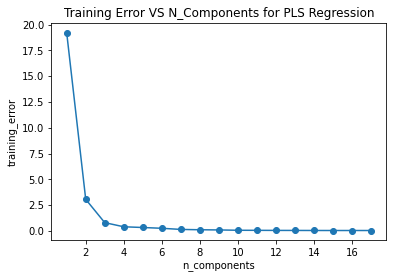

In [53]:
# Visualize the result
plt.plot('n_components', 'training_err', data = result, marker='o')
plt.xlabel('n_components')
plt.ylabel('training_error')
plt.title('Training Error VS N_Components for PLS Regression')
plt.show()

In [54]:
# It is found that n_components = 3 gives a decent model
# PLS Regression has built-in scaler. No need to standardize data.
mod_7 = PLSRegression(n_components = 3)
mod_7.fit(train_X, train_Y)

PLSRegression(n_components=3)

# (d) Make predictions and evaluate Testing error

In [55]:
# Create a dictionary to store model names and corresponding testing error
mod_te = {'model':[], 'testing_error':[]}

In [56]:
# mod_1: Linear Regression using all variables
pred_1 = mod_1.predict(mod_1_test_X_std)
mod_te['model'].append('mod_1')
mod_te['testing_error'].append(calc_error(pred_1, test_Y))

In [57]:
# mod_2: Linear Regression using the best 5 variables
pred_2 = mod_2.predict(mod_2_test_X_std)
mod_te['model'].append('mod_2')
mod_te['testing_error'].append(calc_error(pred_2, test_Y))

In [58]:
# mod_3: Linear Regression using variables selected by AIC
pred_3 = mod_3.predict(mod_3_test_X_std)
mod_te['model'].append('mod_3')
mod_te['testing_error'].append(calc_error(pred_3, test_Y))

In [59]:
# mod_4: Ridge regression
pred_4 = mod_4.predict(mod_4_test_X_std)
mod_te['model'].append('mod_4')
mod_te['testing_error'].append(calc_error(pred_4, test_Y))

In [60]:
# mod_5: LASSO
pred_5 = mod_5.predict(mod_5_test_X_std)
mod_te['model'].append('mod_5')
mod_te['testing_error'].append(calc_error(pred_5, test_Y))

In [61]:
# mod_6: Principal Component Regression
test_X_reduced = pca.transform(mod_6_test_X_std)
pred_6 = mod_6.predict(test_X_reduced)
mod_te['model'].append('mod_6')
mod_te['testing_error'].append(calc_error(pred_6, test_Y))

In [62]:
# mod_7: Partial least squares
pred_7 = mod_7.predict(test_X)
pred_7_flat = [item for sublist in pred_7 for item in sublist]
mod_te['model'].append('mod_7')
mod_te['testing_error'].append(calc_error(pred_7_flat, test_Y))

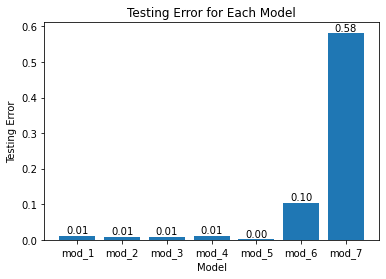

In [63]:
# Visualize the testing errors for each model
fig = plt.bar(mod_te['model'], mod_te['testing_error'])
plt.bar_label(fig, fmt = '%.2f')
plt.xlabel('Model')
plt.ylabel('Testing Error')
plt.title('Testing Error for Each Model')
plt.show()

# (e) Monte Carlo CV for each model

In [65]:
# Create a dictionary to store CV results
cv_result = {}

In [66]:
# Remove outliers to keep consistant with previous parts
data = fat.drop(show_outlier(train, 3).index)

In [67]:
# mod_1
cv_result['mod_1'] = MC_CV(mod_1, data, 25, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [68]:
# mod_2
# Get columns needed for mod_2
mod_2_cols = list(best_five['Best_param'])
mod_2_cols.append('brozek')
# Subset data for mod_2
mod_2_data = data.loc[:, mod_2_cols]
cv_result['mod_2'] = MC_CV(mod_2, mod_2_data, 25, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [69]:
# mod_3
# Get columns needed for mod_3
mod_3_cols = list(best_param_aic)
mod_3_cols.append('brozek')
# Subset data for mod_3
mod_3_data = data.loc[:, mod_3_cols]
cv_result['mod_3'] = MC_CV(mod_3, mod_3_data, 25, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [70]:
# mod_4
cv_result['mod_4'] = MC_CV(mod_4, data, 25, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [71]:
# mod_5
cv_result['mod_5'] = MC_CV(mod_5, data, 25, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [73]:
# mod_6
# Since mod_6 (PCA Regression) includes an extra PCA step after each train-test split, the MC_CV() function can not be used.
# CV is performed in a loop
mod_6_cv = []
for i in tqdm(range(100)):
    # Random sample training and testing set
    mod_6_test = data.sample(25)
    mod_6_train = data.drop(labels = mod_6_test.index)
    
    # Split X and Y
    mod_6_train_X = mod_6_train.drop('brozek', axis = 1)
    mod_6_train_Y = mod_6_train.loc[:,'brozek']
        
    mod_6_test_X = mod_6_test.drop('brozek', axis = 1)
    mod_6_test_Y = mod_6_test.loc[:, 'brozek']
    
    # Standardize data for PCA in mod_6
    sc_pca = StandardScaler()
    sc_pca.fit(mod_6_train_X)
    mod_6_train_X_std = sc_pca.transform(mod_6_train_X)
    mod_6_test_X_std = sc_pca.transform(mod_6_test_X)
    
    # Use PCA to reduce X
    temp_pca = PCA(n_components = 0.95)
    temp_mod = LinearRegression()
    mod_6_train_X_reduced = temp_pca.fit_transform(mod_6_train_X_std)
    # Fit the model
    temp_mod.fit(mod_6_train_X_reduced, mod_6_train_Y)
    # Make prediction
    mod_6_test_X_reduced = temp_pca.transform(mod_6_test_X_std)
    p = temp_mod.predict(mod_6_test_X_reduced)
    
    # Calculate Testing Error
    mod_6_cv.append(calc_error(p, mod_6_test_Y))
        
cv_result['mod_6'] = mod_6_cv

  0%|          | 0/100 [00:00<?, ?it/s]

In [74]:
# mod_7
# Since PLSRegression() has built-in scaling mechanism, MC_CV() is not used here.
mod_7_cv = []
for i in tqdm(range(100)):
    # Random sample training and testing set
    mod_7_test = data.sample(25)
    mod_7_train = data.drop(labels = mod_7_test.index)
    
    # Split X and Y
    mod_7_train_X = mod_7_train.drop('brozek', axis = 1)
    mod_7_train_Y = mod_7_train.loc[:,'brozek']
    mod_7_test_X = mod_7_test.drop('brozek', axis = 1)
    mod_7_test_Y = mod_7_test.loc[:, 'brozek']
    
    # Train the model
    pls = PLSRegression(n_components = 3)
    pls.fit(mod_7_train_X, mod_7_train_Y)
    
    # Make prediction
    p7 = pls.predict(mod_7_test_X)
    p7_flat = [item for sublist in p7 for item in sublist]

    
    # Calculate Testing Error
    mod_7_cv.append(calc_error(p7_flat, mod_7_test_Y))
    
cv_result['mod_7'] = mod_7_cv
        

  0%|          | 0/100 [00:00<?, ?it/s]

In [75]:
# Visulaize the CV result for each model
cv_df = pd.DataFrame.from_dict(cv_result)

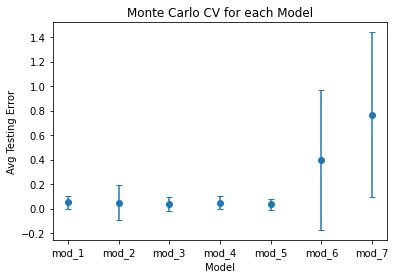

In [76]:
names = cv_df.columns
mean = cv_df.mean()
std = cv_df.std()

plt.errorbar(x = names, y = mean, yerr = std, linestyle='None', marker='o', capsize = 3)
plt.xlabel('Model')
plt.ylabel('Avg Testing Error')
plt.title('Monte Carlo CV for each Model')

plt.show()

In [77]:
# Show the descriptive statistics of testing error for each model
cv_df.describe()

,mod_1,mod_2,mod_3,mod_4,mod_5,mod_6,mod_7
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.050507,0.049218,0.038833,0.049296,0.037095,0.396600,0.767469
std,0.051657,0.139711,0.059113,0.051363,0.044957,0.571344,0.671089
min,0.004658,0.001773,0.002460,0.003483,0.001276,0.071533,0.212682
25%,0.010836,0.005633,0.006640,0.009374,0.002548,0.151472,0.392159
50%,0.023432,0.012022,0.012720,0.017770,0.015792,0.202483,0.529017
75%,0.083269,0.067328,0.061746,0.081728,0.064746,0.279761,0.717590
max,0.205924,1.359753,0.468714,0.201652,0.197267,2.443244,3.040749
